# Example: plot raw data from participant 1

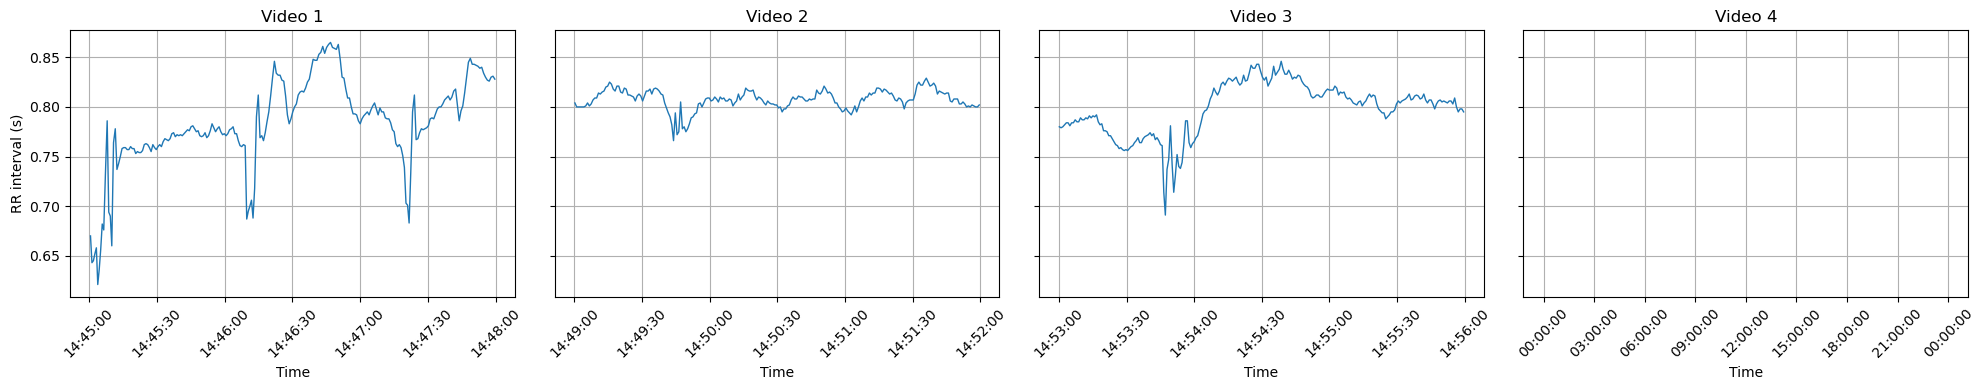

In [ ]:
from matplotlib.dates import DateFormatter
import pandas as pd
import matplotlib.pyplot as plt

# Load participant1 data
data = pd.read_csv("../trials_hr/participant1.csv", skiprows=4)
RR_seconds = data['ArtifactCorrectedRR'] / 1000
data['ts'] = pd.to_datetime(data['ts'])

# Manual video boundaries (start, end) for each stimulus
stimuli = [
    (pd.to_datetime("2025-11-12 14:45:00"), pd.to_datetime("2025-11-12 14:48:00")),
    (pd.to_datetime("2025-11-12 14:49:00"), pd.to_datetime("2025-11-12 14:52:00")),
    (pd.to_datetime("2025-11-12 14:53:00"), pd.to_datetime("2025-11-12 14:56:00")),
    (pd.to_datetime("2025-11-12 14:58:00"), pd.to_datetime("2025-11-12 14:59:00"))
]

fig, axes = plt.subplots(1, len(stimuli), figsize=(5 * len(stimuli), 4), sharey=True)
if len(stimuli) == 1:
    axes = [axes]

for idx, (start, end) in enumerate(stimuli):
    mask = (data['ts'] >= start) & (data['ts'] <= end)
    segment = data[mask]
    
    axes[idx].plot(segment['ts'], segment['ArtifactCorrectedRR'] / 1000, '-', linewidth=1)
    axes[idx].set_title(f'Video {idx + 1}')
    axes[idx].set_xlabel('Time')
    axes[idx].grid(True)
    axes[idx].xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    for lbl in axes[idx].get_xticklabels():
        lbl.set_rotation(45)

axes[0].set_ylabel('RR interval (s)')
fig.tight_layout()
plt.show()

# Setup

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

with open("experiment_with_heart_rate.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

# A. Plot heart rate over the entire experiment (one participant)

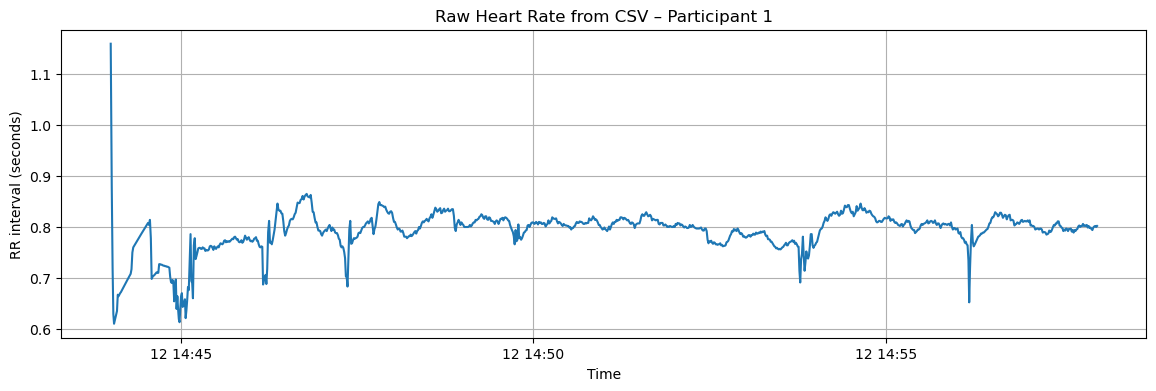

In [ ]:
# -------- 1) helper: read raw HR CSV --------
def load_hr_file(path: str) -> pd.DataFrame:
    """
    Load a participantN.csv HR file into a DataFrame with:
    RR, ArtifactCorrectedRR, RawArtifact, ts
    """
    lines = Path(path).read_text(encoding="utf-8").splitlines()

    # find header line (the one containing RR and ts)
    header_idx = None
    for i, line in enumerate(lines):
        if "RR" in line and "ts" in line:
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not find header with 'RR' and 'ts' in {path}")

    header_line = lines[header_idx].strip()

    # detect delimiter
    if ";" in header_line and "," not in header_line:
        delim = ";"
    else:
        delim = ","

    header = [h.strip() for h in header_line.split(delim)]

    # data rows
    data_rows = []
    for line in lines[header_idx + 1 :]:
        if not line.strip():
            continue
        parts = [p.strip() for p in line.split(delim)]
        if len(parts) != len(header):
            continue
        data_rows.append(parts)

    df = pd.DataFrame(data_rows, columns=header)

    # numeric columns
    for col in ["RR", "ArtifactCorrectedRR", "RawArtifact"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "RawArtifact" in df.columns:
        df["RawArtifact"] = df["RawArtifact"].fillna(0).astype(int)

    if "ts" in df.columns:
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")

    df = df.dropna(subset=["ts", "ArtifactCorrectedRR"])
    return df

# -------- 2) plot raw HR from CSV (no video cutting) --------
def plot_raw_hr_csv(participant_id: int):
    path = f"../trials_hr/participant{participant_id}.csv"  # adjust folder if needed
    df = load_hr_file(path)

    df["RR_seconds"] = df["ArtifactCorrectedRR"] / 1000.0

    plt.figure(figsize=(14, 4))
    plt.plot(df["ts"], df["RR_seconds"], linestyle="-")
    plt.title(f"Raw Heart Rate from CSV – Participant {participant_id}")
    plt.xlabel("Time")
    plt.ylabel("RR interval (seconds)")
    plt.grid(True)
    plt.show()
plot_raw_hr_csv(1)


# B. Plot heart rate per video

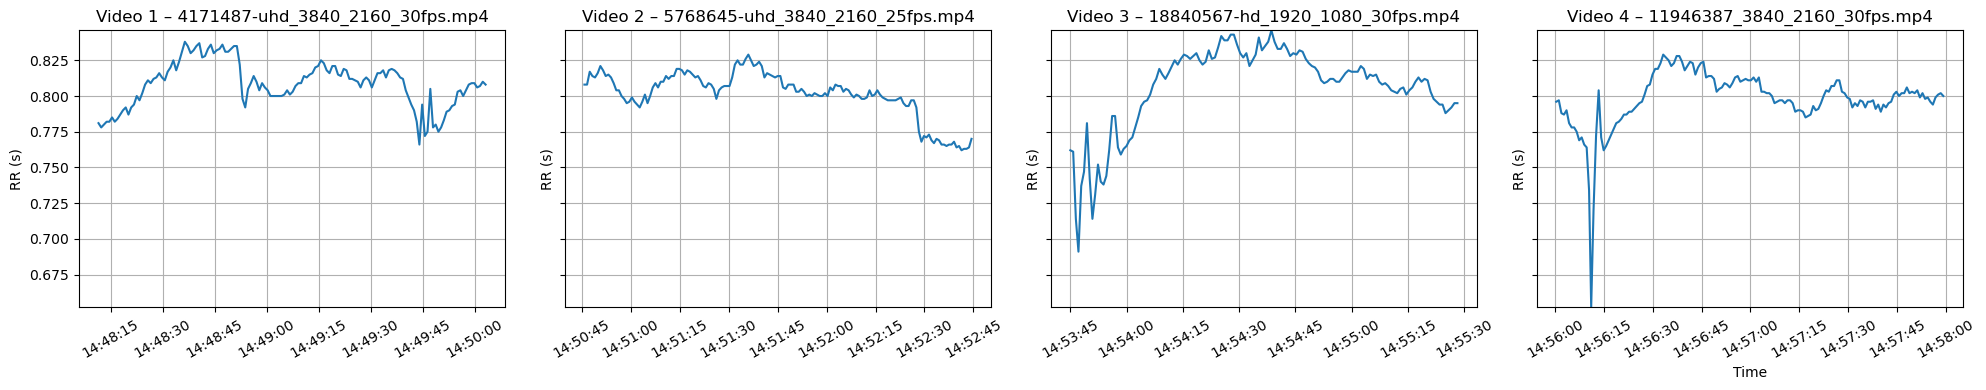

In [24]:
def plot_hr_by_video(participant_id):
    p = next(pp for pp in participants if pp["participant_id"] == participant_id)
    n = len(p["stimuli"])
    if n == 0:
        print("No stimuli for this participant")
        return

    # compute global y-limits
    mins, maxs = [], []
    for stim in p["stimuli"]:
        dfh = pd.DataFrame(stim.get("heart_rate", []))
        if "ArtifactCorrectedRR" in dfh.columns and not dfh.empty:
            vals = pd.to_numeric(dfh["ArtifactCorrectedRR"], errors="coerce") / 1000.0
            mins.append(vals.min()); maxs.append(vals.max())
    ymin, ymax = (min(mins), max(maxs)) if mins else (0, 1)

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)
    if n == 1:
        axes = [axes]

    for stim, ax in zip(p["stimuli"], axes):
        df = pd.DataFrame(stim.get("heart_rate", []))
        if df.empty or "ts" not in df.columns or "ArtifactCorrectedRR" not in df.columns:
            ax.text(0.5, 0.5, "No HR data", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(f"Video {stim['id']} – {stim.get('video_id','')}")
            ax.grid(True)
            ax.set_ylim(ymin, ymax)
            continue

        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        df["RR_seconds"] = pd.to_numeric(df["ArtifactCorrectedRR"], errors="coerce") / 1000.0
        df = df.dropna(subset=["ts", "RR_seconds"]).sort_values("ts")

        ax.plot(df["ts"], df["RR_seconds"], linestyle="-")
        ax.set_title(f"Video {stim['id']} – {stim['video_id']}")
        ax.set_ylabel("RR (s)")
        ax.grid(True)
        ax.set_ylim(ymin, ymax)
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(30)

    axes[-1].set_xlabel("Time")
    fig.tight_layout()
    plt.show()

plot_hr_by_video(1)


# C. Plot whole experiment with video boundaries

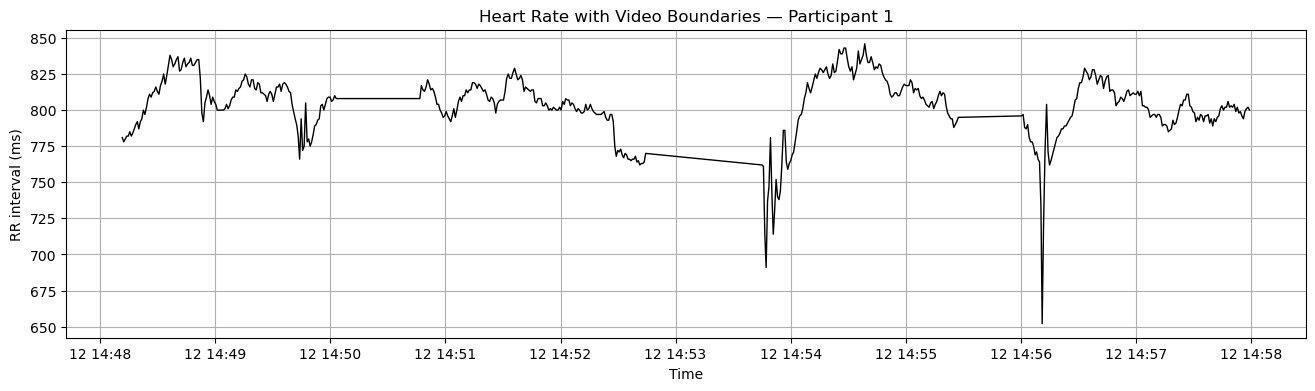

In [42]:
def plot_hr_with_videos(participant_id):
    p = next(pp for pp in participants if pp["participant_id"] == participant_id)
    rows = []
    for stim in p["stimuli"]:
        rows.extend(stim.get("heart_rate", []))
    df = pd.DataFrame(rows)
    if df.empty:
        print("No HR data"); return

    # prefer ArtifactCorrectedRR, fallback to RR
    if "ArtifactCorrectedRR" in df.columns:
        df["RR_ms"] = pd.to_numeric(df["ArtifactCorrectedRR"], errors="coerce")
    else:
        df["RR_ms"] = pd.to_numeric(df.get("RR"), errors="coerce")

    # robust timestamp parsing for mixed formats
    df["ts"] = pd.to_datetime(df["ts"].astype(str), errors="coerce")
    df = df.dropna(subset=["ts", "RR_ms"]).sort_values("ts")

    plt.figure(figsize=(16, 4))
    plt.plot(df["ts"], df["RR_ms"], color="black", linewidth=1, label="RR (ms)")

    ymax = df["RR_ms"].max()
    for stim in p["stimuli"]:
        start = stim.get("video_start")
        end = stim.get("video_end")
        if start:
            s = pd.to_datetime(str(start), errors="coerce")
            if pd.notna(s):
                plt.axvline(s, color="green", linestyle="--", alpha=0.7)
                plt.text(s, ymax, f"Video {stim.get('id')}", rotation=90, verticalalignment="top")
        if end:
            e = pd.to_datetime(str(end), errors="coerce")
            if pd.notna(e):
                plt.axvline(e, color="red", linestyle="--", alpha=0.7)

    plt.title(f"Heart Rate with Video Boundaries — Participant {participant_id}")
    plt.xlabel("Time")
    plt.ylabel("RR interval (ms)")
    plt.grid(True)
    plt.show()

plot_hr_with_videos(1)

# D. Plot raincloud of heart rate per trial